### We are going to implement the VGG model from scratch in pytorch

Made with reference to this wonderful video tutorial by [Aladdin Persson](https://www.youtube.com/watch?v=ACmuBbuXn20)

Paper available at [here](https://arxiv.org/pdf/1409.1556.pdf)

This model is nicely summarized in this diagram:

![](https://www.researchgate.net/profile/Jose_Cano31/publication/327070011/figure/fig1/AS:660549306159105@1534498635256/VGG-16-neural-network-architecture.png) 



In [38]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torch.optim as optim
import torch.nn.functional as F

Now according to the paper, the VGG kernel size is 3x3 with stride of 1 and padding of 0, which is same convolution. if you look at the table implementing the architecture of VGG 16, you will notice the specification. Ill make an array of that, the numbers in the array means channels while the `M` stands for maxpooling layer.

![](https://raw.githubusercontent.com/yashk2810/yashk2810.github.io/master/images/vgg-16-architecture.png)

But I guess this picture makes more sense, in terms of implementation details.

![](https://miro.medium.com/max/3818/1*MEuoX8lso9vNn8savmTwHQ.png)

In [39]:
VGG16 = [64, 64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M', 512,512,512,'M' ]

If you look at the dataset provided you'll notice that there are five different poses of yoga.

In [40]:
num_classes = 5
in_channels = 3

In [41]:
#testing
a = []
b = [2]
a += b
# print(a += b)
a.append(b)
print(a)
# c = a+=b
print(*a)

[2, [2]]
2 [2]


In [42]:
class genVGG(nn.Module):
    def __init__(self, in_channels=in_channels, num_classes=num_classes, arch=VGG16):
        super(genVGG, self).__init__()
        self.in_channels = in_channels
        self.conv_layer = self.create_conv_layers(arch)
        
        self.fc = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
        
    def create_conv_layers(self, arch):
        layers = []
        
        in_channels = self.in_channels
        
        for x in arch:
            if isinstance(x, int):
                out_channels = x
                layers += [
                            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), padding=(1,1), stride=(1,1)), 
                            nn.BatchNorm2d(x),
                            nn.ReLU()
                          ]
                
                in_channels = x
            
            if isinstance(x, str):
                layers += [nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))]
        
#         print("Model Summary: ")
#         for layer in layers:
#             print(layer)
#         print(f"conv Model loaded. number of layers : {len(layers)}")

            
        return nn.Sequential(*layers)
                
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x
        

In [43]:
model_1 = genVGG()

Lets test the model. We will use `torch.randn` to create a tensor.

In [44]:
x = torch.randn(1,3,224,224)
y = model_1(x)
y.shape

torch.Size([1, 5])

given below is a vgg implementaion I tried.

In [45]:
class selfVGG(nn.Module):
    def __init__(self,num_classes=5):
        super(VGG, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3), padding=(0,0), stride=(1,1))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=(0,0), stride=(1,1))
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3),padding = (0,0), stride=(1,1))
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), padding=(0,0), stride=(1,1))
        self.linear1 = nn.Linear(73728, num_classes)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.maxpool(out)
        out = F.relu(self.conv2(out))
        out = self.maxpool(out)
        out = F.relu(self.conv3(out))
        out = self.maxpool(out)
        out = F.relu(self.conv4(out))
        out = self.maxpool(out)
        out = out.reshape(out.size(0), -1)
        out = self.linear1(out)
        return out
        

In [46]:
import os

class_names = []
labels = []
all_inputs = []

acceptable_formats = ['jpg', 'JPG', 'jpeg', 'JPEG']
root_dir = '../input/yoga-poses-dataset/DATASET/TRAIN'
for idx, name in enumerate(os.listdir(root_dir)):
    class_names.append(name)
    
    for root, subdir,files in os.walk(os.path.join(root_dir, name)):
        for file in files:
            if file.split('.')[1] in acceptable_formats:
                all_inputs.append(os.path.join(root_dir, name, file))
                labels.append(idx)
            else: 
#                 print(f"file {file} not included.")
                continue

all_inputs[0], labels[0], len(all_inputs), len(labels)

('../input/yoga-poses-dataset/DATASET/TRAIN/downdog/00000335.jpg',
 0,
 1007,
 1007)

In [47]:
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True

import torchvision.transforms as transform

In [48]:
my_transform = transform.Compose([
    transform.Resize((224,224)),
    transform.ToTensor()
])

In [49]:
class_names = []

### Problems with the dataset

This dataset is actually a headache because of all the png file which have dimension 4 compared to jpeg files of dimension 3, mixed with some single channel images. So we need to cater for that while building dataset.

I am going to skip all images that have incorrect dimension.

In [50]:
class yogaDataset(Dataset):
    def __init__(self, root_dir, transform=my_transform):

        self.labels = []
        self.all_inputs = []
        self.transform = transform
        
        self.total_inputs = 0
        for idx, name in enumerate(os.listdir(root_dir)):
            class_names.append(name)

            for root, subdir,files in os.walk(os.path.join(root_dir, name)):
                print(f"Total files in {name}: {len(files)}")
                self.total_inputs += len(files)
                for file in files:
                    if file.split('.')[1] in acceptable_formats:
                        current_file = os.path.join(root_dir, name, file)
                        
                        #checking for dimensions
                        img = Image.open(current_file)
                        
#                         print('current file : ', current_file, " : ")
                        
                        try:
                            if (transform):
                                img = self.transform(img)
                            
                                if(img.size(0) == 3):
                                    self.all_inputs.append(current_file)
                                    self.labels.append(idx)
#                                     print("added")
                                else:
#                                     print(f"{img.size()} not included. Incorrect dimension!")
                                    continue
                                    
                        except Exception as e:
#                             print(e, f"not included! transform error!")
                            continue
                            
                        
                    else:
                        continue
#                         print(f"not included. Incorrect format!")
        print("Total files processed: ", len(self.all_inputs), "/", self.total_inputs)
                    
                          
    def __len__(self):
        return len(self.all_inputs)
    
    def __getitem__(self, index): 
        
#         print(f"accessed: , {all_inputs[index]}")
        
        img = Image.open(all_inputs[index])
        
        if(self.transform is not None):
            img = self.transform(img)
        
        target = torch.tensor(self.labels[index])
        return img, target

In [51]:
# train_dataset = yogaDataset('../input/yoga-poses-dataset/DATASET/TRAIN', transform=my_transform)
test_dataset = yogaDataset('../input/yoga-poses-dataset/DATASET/TEST', transform=my_transform)

Total files in downdog: 97
Total files in tree: 69
Total files in plank: 115
Total files in warrior2: 109
Total files in goddess: 80
Total files processed:  431 / 470


This dataset has a lot of errors. and random pictures scraped form web scraped together.

test dataset length:  431
warrior2


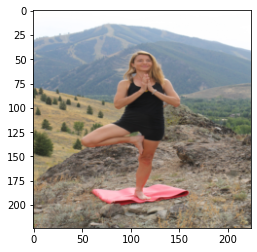

In [52]:
x,y = test_dataset[300]

# print('total dataset size: ', train_dataset.__len__())
print('test dataset length: ', test_dataset.__len__())
import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))
print(class_names[int(y)])



In [53]:
# for i in range(len(train_dataset)):
#     x, y = train_dataset[i]
#     if x.shape[0] != 3:
#         print(x.shape)

I am going to use a totally different dataset. Just to see whether its really the dataset that is causing the problems.

In [54]:
transformations = transform.Compose([
    transform.Resize(255),
    transform.CenterCrop(224),
    transform.ToTensor(),
    transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [55]:
train_set = datasets.ImageFolder("../input/100-bird-species/train", transform = transformations)
test_set = datasets.ImageFolder("../input/100-bird-species/test", transform = transformations)

test dataset size:  1350
train dataset length:  38518
212


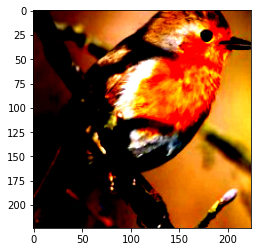

In [56]:
x,y = train_set[30000]

print('test dataset size: ', test_set.__len__())
print('train dataset length: ', train_set.__len__())
import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))
print(int(y))


The amount of data is huge here so lets create a subset.

In [57]:
import numpy

In [58]:
train_subset = torch.utils.data.Subset(train_set, numpy.random.choice(len(train_set), 5000, replace=False))

In [59]:
train_dataloader = DataLoader(dataset=train_subset, batch_size=64, shuffle=True )
test_dataloader = DataLoader(dataset=test_set, batch_size=64, shuffle=True)

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
model = genVGG().to(device=device)

lets try and download a vgg model

In [62]:
import torchvision.models as models

model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [63]:
num_classes =270

In [75]:
# model.avgpool = torch.nn.Identity()
model.classifier[6] = nn.Linear(in_features=4096, out_features=270, bias=True)

In [76]:
model = model.to(device=device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [77]:
# testing
x = torch.randn(10, 3, 224, 224).to(device=device)
y = model(x)
y.shape

torch.Size([10, 270])

In [78]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_criterion = nn.CrossEntropyLoss()

In [79]:
for epoch in range(5):
    try:
        for data, target in train_dataloader:      
                data = data.to(device=device)
                target = target.to(device=device)

                score = model(data)
                optimizer.zero_grad()

                loss = loss_criterion(score, target)
                
                loss.backward()

                optimizer.step()
    except Exception as e:
        print(e)
    print(f"For epoch {epoch}, the loss is {loss}")

            
            

For epoch 0, the loss is 4.613306045532227
For epoch 1, the loss is 0.3527037799358368
For epoch 2, the loss is 0.0005922340205870569
For epoch 3, the loss is 0.25954195857048035
For epoch 4, the loss is 0.00014218880096450448


In [80]:
def check_accuracy(model, loader):
    model.eval()
    correct_samples = 0
    total_samples = 0
    
    for x, y in loader:
        x = x.to(device=device)
        y = y.to(device=device)
        
        score = model(x)
        _, predictions = score.max(1)
        correct_samples += (y==predictions).sum()
        total_samples += predictions.size(0)
    
    model.train()
    print(f'total correct {correct_samples} out of {total_samples} with accuracy of {(correct_samples/total_samples)*100}%')

In [81]:
check_accuracy(model,train_dataloader)
check_accuracy(model, test_dataloader)

total correct 4889 out of 5000 with accuracy of 97.77999877929688%
total correct 1048 out of 1350 with accuracy of 77.62963104248047%


Turns out you cannot train VGG implementation from scratch like that.